In [1]:
import pandas as pd
import geopandas as gpd
import shapely.wkt
import networkx as nx
import numpy as np
import matplotlib
import nltk
import matplotlib.pyplot as pltimport
import spacy
from shapely.geometry import shape
from pyvis.network import Network
from IPython.core.display import display, HTML
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib
import matplotlib.pyplot as plt
# import these modules
from nltk.stem import WordNetLemmatizer

# Run once "python -m spacy download en_core_web_lg" before the following
nlp = spacy.load('en_core_web_lg')

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
2023-03-03 11:34:46.149332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Manual steps
####  Store doc as a txt file (one for each safe, unsafe, attr, unattr)
####  Correct mispellings
#### Result 4 txt files 

# Create word-head graph and identify nodes with highest betweeness

In [3]:
# for each text file
for file in ['text_safe_peruser','text_unsafe_peruser','text_attr_peruser','text_unattr_peruser']:

  with open('../data/' + file +".txt") as f:
      text_edit = f.read()

  # additional manual adaptations
  text_edit = text_edit.replace('roadwork', 'construction site')
  text_edit = text_edit.replace('road', 'street')
  text_edit = text_edit.replace('building work', 'construction site')
  text_edit = text_edit.replace('work', 'construction')
  text_edit = text_edit.replace('look', '')
  text_edit = text_edit.replace(' s ', '')
  text_edit = text_edit.lower()

  # create combos of word-head
  doc = nlp(text_edit)
  text_list = []
  head_list = []
  for token in doc:
      if token.is_alpha:
          if not token.is_stop:
              text_list.append(token.lemma_)
              head_list.append(token.head.lemma_.lower())
  df = pd.DataFrame(list(zip(text_list, head_list)), columns =['text', 'head'])
  combos = df.groupby(['text','head']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False)
  # remove self-loops
  combos = combos.query("text != head")
  # inverse weighting so more counts mean smaller edge weight
  combos['count'] = 1/combos['count']

  # make graph
  G = nx.from_pandas_edgelist(combos, source='text', target='head', edge_attr='count')
  G.remove_edges_from(nx.selfloop_edges(G))
  # manual adaptations of nodes without meaning
  G.remove_node('of')
  G.remove_node('be')
  G.remove_node('for')
  G.remove_node('in')
  G.remove_node('lot')
  G.remove_node('to')
  G.remove_node('on')
  G.remove_node('ing')
  G.remove_node('seem')

  # calculate centrality
  degCent = nx.degree_centrality(G)
  #Descending order sorting centrality
  degCent_sorted=dict(sorted(degCent.items(), key=lambda item: item[1],reverse=True))
  #Computing betweeness
  # betCent = nx.betweenness_centrality(G, weight='count', normalized=True, endpoints=True)
  #Descending order sorting betweeness
  # betCent_sorted=dict(sorted(betCent.items(), key=lambda item: item[1],reverse=True))
  N_top = 15
  # keys_deg_top=list(degCent_sorted)[0:N_top]
  keys_bet_top=list(degCent_sorted)[0:N_top]
  # top = list(set(keys_bet_top) & set(keys_deg_top))

  top = keys_bet_top
  #manual adaptation to only keep street elements
  if 'area' in top:
    top.remove('area')
  if 'street' in top:
    top.remove('street')
  if 'place' in top:
    top.remove('place')

  print(file, top)

  # for node in top[0:3]:
  for node in ['building']:
    subg=nx.Graph()
    #Find all neighbors of node
    neighbors=G.neighbors(node) 
    edges = []
    for neighs in neighbors:
        edges.append((neighs,G[node][neighs]['count']))
    edges_sorted = sorted(edges, key=lambda tup: tup[1])
    # print(edges_sorted)
    for i in edges_sorted[0:10]:
        subg.add_edge(node,i[0],count=i[1])

    net = Network(height='1000px', width='90%')
    
    net.from_nx(subg)
    net.save_graph(file + '_' + node + 'peruser_subg.html')


text_safe_peruser ['building', 'people', 'car', 'safe', 'traffic', 'residential', 'neighborhood', 'open', 'space', 'with', 'business', 'shop']
text_unsafe_peruser ['building', 'construction', 'traffic', 'car', 'people', 'feel', 'graffiti', 'dark', 'safe', 'like', 'light', 'crossing']
text_attr_peruser ['building', 'tree', 'house', 'nice', 'shop', 'architecture', 'clean', 'good', 'space', 'business', 'attractive', 'beautiful']
text_unattr_peruser ['building', 'construction', 'ugly', 'tree', 'car', 'graffiti', 'make', 'shop', 'space', 'nice', 'house', 'site']


In [4]:
# Finding Unions
safe = ['building', 'people', 'car', 'traffic', 'residential']
unsafe = ['building', 'construction', 'traffic', 'car', 'people']
attr = ['building', 'tree', 'house', 'shop', 'architecture']
unattr = ['building', 'construction', 'tree', 'car', 'graffiti']

print(set(safe) & set(unsafe))
print(set(safe) & set(unattr))
print(set(attr) & set(unattr))
print(set(unattr) & set(unsafe))
print(set(attr) & set(safe))


print(set(safe) & set(unsafe)& set(attr) & set(unattr))

{'people', 'building', 'car', 'traffic'}
{'building', 'car'}
{'building', 'tree'}
{'building', 'car', 'construction'}
{'building'}
{'building'}


text_unsafe_peruser


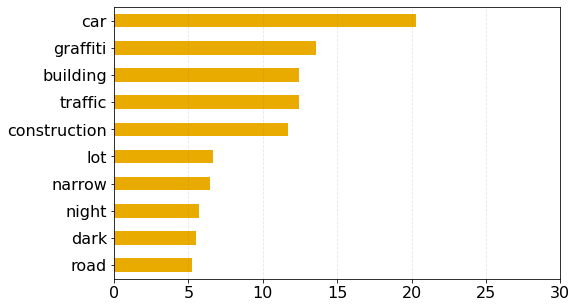

text_safe_peruser


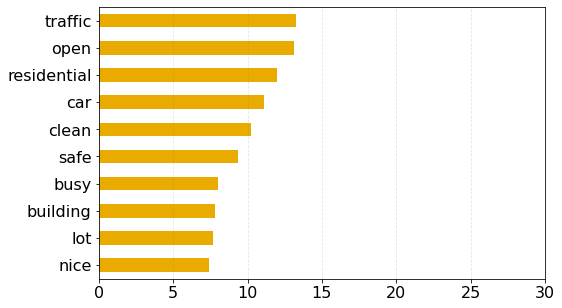

text_attr_peruser


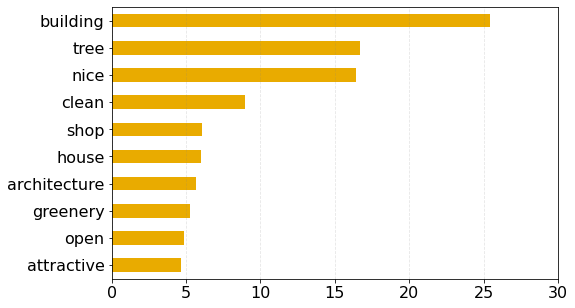

text_unattr_peruser


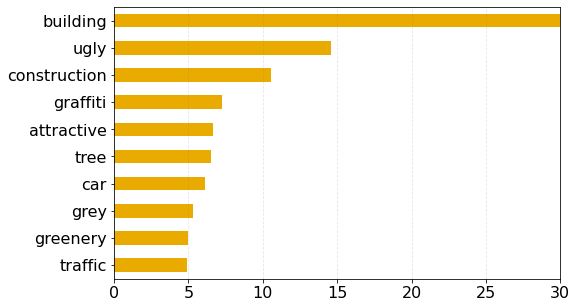

In [7]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()


for file in ['text_unsafe_peruser','text_safe_peruser','text_attr_peruser','text_unattr_peruser']:
    print(file)
    with open('../data/' + file +".txt") as f:
        text_edit= f.read()

    text_edit = text_edit.replace('.','')
    text_edit = text_edit.replace(',','')
    text_edit = text_edit.replace(' road ', ' street ')
    text_edit = text_edit.replace(' street ', '')

    text_edit = text_edit.replace(' work ', ' construction ')
    text_edit = text_edit.replace(' look ', '')
    text_edit = text_edit.replace(' area ', '')
    text_edit = text_edit.replace(' lot ', '')

    text_edit = text_edit.replace(' ing ', '')
    text_edit = text_edit.replace(' s ', '')
    text_edit = text_edit.lower()


    text_tokens = word_tokenize(text_edit)
    text_tokens = [word for word in text_tokens if not word in stopwords.words()]
    text_tokens = [lemmatizer.lemmatize(w) for w in text_tokens]


    counts = Counter(text_tokens)
    df = pd.DataFrame(counts.most_common(10), columns=['Characteristics','Count'])
    df = df.sort_values(by='Count')
    df['perc'] = (df.Count/df.Count.sum())*100


    pd.get_option("display.max_columns")
    params = {'axes.titlesize':'18',
            'xtick.labelsize':'16',
            'ytick.labelsize':'16'}
    matplotlib.rcParams.update(params)
    color= {} 
    color['5']= "#E9AB00"
    color['10'] = "#7B0E78"
    color['15'] = None

    ax = df.plot.barh(x='Characteristics', y='perc', sort_columns=False, color=color['5'], legend=False, grid=False, zorder=1, figsize=(8,5))
    # ax.grid(axis='x')
    ax.xaxis.grid(True, linestyle='dashed', alpha=0.2, color='gray')
    ax.set_facecolor('white')

    plt.xlabel('', fontsize=18, weight='bold')
    plt.ylabel('', fontsize=18, weight='bold')
    plt.xlim(0,30)
    plt.show()
    # plt.savefig('../img/wordclouds/word_frequency_' + file + '.png')